### Assignment 2

NAME : WANG YUNGE  
STUDENT ID : A0253794R

1.The function and test results are as follows：

In [241]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import bisect

In [242]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    BinaryCall = 'BinaryCall'
    BinaryPut = 'BinaryPut'

# Black-Scholes analytic pricer
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)


In [243]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [244]:
def trinomialPricerAnchor(S, r, q, vol, trade, n, K):
    lmda = math.sqrt(3)
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    
    st = [abs(S * u ** (n - i) - K) for i in range(2*n + 1)]
    locat_st = st.index(min(st))
    lmda = np.log(K/S)/(vol * math.sqrt(t) * (n - locat_st))
    
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

C:\Users\wyg32\AppData\Local\Temp\ipykernel_26064\2497104884.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  lmda = np.log(K/S)/(vol * math.sqrt(t) * (n - locat_st))
C:\Users\wyg32\AppData\Local\Temp\ipykernel_26064\2497104884.py:24: RuntimeWarning: invalid value encountered in double_scalars
  continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)


Text(0.5, 1.0, 'pricing errors of European Call trinomial tree pricer')

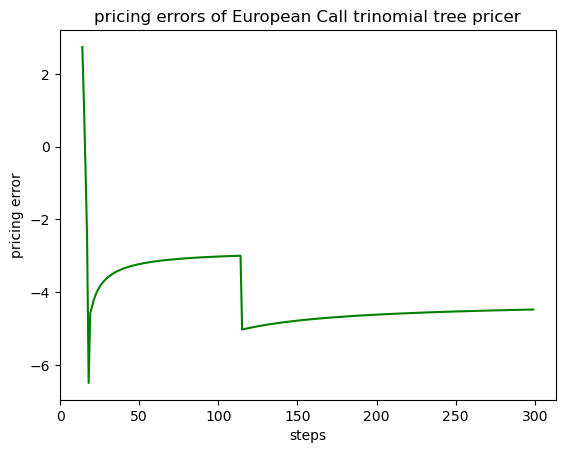

In [245]:
#European Call option test
opt = EuropeanOption(1, 105, PayoffType.Call)
S, r, q, vol = 100, 0.01, 0, 0.2
bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
TriErrs = [math.log(abs(trinomialPricerAnchor(S, r, q, vol, opt, i, opt.strike) - bsprc)) for i in range(10, 300)]
plt.plot(range(10, 300), TriErrs, 'g')
plt.xlabel("steps")
plt.ylabel("pricing error")
plt.title("pricing errors of European Call trinomial tree pricer")

C:\Users\wyg32\AppData\Local\Temp\ipykernel_26064\2497104884.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  lmda = np.log(K/S)/(vol * math.sqrt(t) * (n - locat_st))


Text(0.5, 1.0, 'pricing errors of Binary Call trinomial tree pricer')

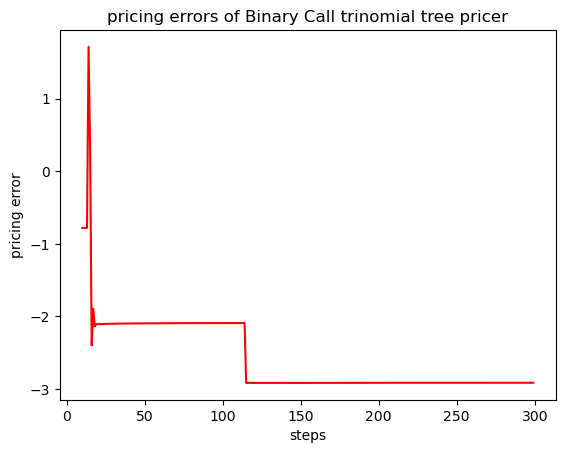

In [246]:
#Binary Call option test
opt = EuropeanOption(1, 105, PayoffType.BinaryCall)
S, r, q, vol = 100, 0.01, 0, 0.2
bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
TriErrs = [math.log(abs(trinomialPricerAnchor(S, r, q, vol, opt, i, opt.strike) - bsprc)) for i in range(10, 300)]
plt.plot(range(10, 300), TriErrs, 'r')
plt.xlabel("steps")
plt.ylabel("pricing error")
plt.title("pricing errors of Binary Call trinomial tree pricer")

2.The function and test results are as follows：

In [247]:
from scipy import optimize

class PayoffType(Enum):
    Call = 0
    Put = 1
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)
        
# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * np.exp((r - q) * T)
    stdev = vol * math.sqrt(T)
    if payoffType == PayoffType.Call:
        f = lambda strike: (fwdDelta(fwd, stdev, strike, payoffType) - delta)
    elif payoffType == PayoffType.Put:
        f = lambda strike: (fwdDelta(fwd, stdev, strike, payoffType) + delta)
    a = 0.1 * S
    b = 2 * S
    strike_res = optimize.brentq(f, a, b)
    return strike_res

In [248]:
# test
S, r, q, vol = 100, 0.03, 0, 0.2
T = 1
delta = 0.5
strike1 = strikeFromDelta(S, r, q, T, vol, delta, PayoffType.Call)
print(strike1)
delta = 0.7
strike2 = strikeFromDelta(S, r, q, T, vol, delta, PayoffType.Call)
print(strike2)

105.12710963760242
94.65986359204527


3.The smilefromMarks function and implied volatility surface are as follows:

In [255]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    vol_call_25 = atmvol + bf25 + rr25/2
    vol_put_25 = atmvol + bf25 - rr25/2
    vol_call_10 = atmvol + bf10 + rr10/2
    vol_put_10 = atmvol + bf10 - rr10/2
    
    strike_call_25 = strikeFromDelta(S, r, q, T, vol_call_25, 0.25, PayoffType.Call)
    strike_put_25 = strikeFromDelta(S, r, q, T, vol_put_25, 0.25, PayoffType.Put)
    strike_call_10 = strikeFromDelta(S, r, q, T, vol_call_10, 0.1, PayoffType.Call)
    strike_put_10 = strikeFromDelta(S, r, q, T, vol_put_10, 0.1, PayoffType.Put)
    strike_atm = S * np.exp((r - q) * T)
    
    vol_dic = {strike_call_25:vol_call_25, strike_put_25:vol_put_25, strike_call_10:vol_call_10, strike_put_10:vol_put_10, strike_atm:atmvol}
    strikes = [strike_call_25, strike_put_25, strike_call_10, strike_put_10, strike_atm]
    strikes.sort()
    print(strikes)
    vols = [vol_dic[key] for key in strikes]
    print(vols)
    return Smile(strikes, vols)

[84.496720719953, 93.70288801201653, 103.0454533953517, 115.62605272394431, 127.1075052657316]
[0.16555, 0.15985, 0.155, 0.15335, 0.15445]


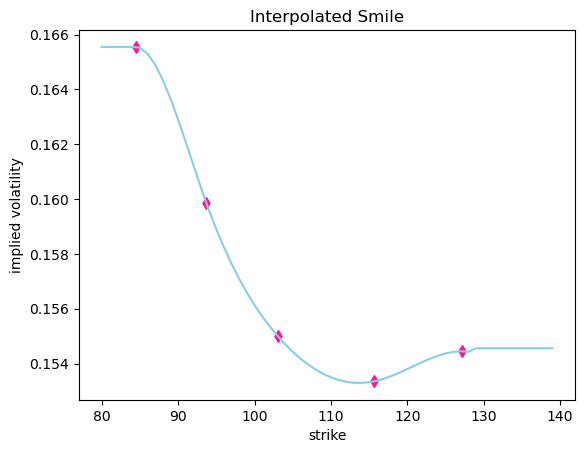

In [256]:
#test and plot Implied Volatility Smile
T = 1  
S = 100  
r = 0.05 
q = 0.02 
atmvol = 0.155  # ATM volatility
bf25 = 0.0016  # 25-delta put bid-ask average
rr25 = -0.0065  # 25-delta risk reversal bid-ask average
bf10 = 0.0050  # 10-delta put bid-ask average
rr10 = -0.0111  # 10-delta risk reversal bid-ask average
smile1 = smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10)
strike_line = [i for i in range(80,140)]
smile2 = [smile1.Vol(i) for i in range(80,140)]
strike_dot = [84.496720719953, 93.70288801201653, 103.0454533953517, 115.62605272394431, 127.1075052657316]
vol_dot = [0.16555, 0.15985, 0.155, 0.15335, 0.15445]
plt.plot(strike_line, smile2, "skyblue")
plt.xlabel("strike")
plt.ylabel("implied volatility")
plt.title("Interpolated Smile")
plt.scatter(strike_dot, vol_dot, c = "deeppink", marker = "d")

In [257]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

[1.2213696516842825, 1.239503344297023, 1.2582261393294654, 1.2770665639323286, 1.294253107366993]
[0.16555, 0.15985, 0.155, 0.15335, 0.15445]
[1.210317785649132, 1.2342909736867753, 1.2584023033201628, 1.2821044280802651, 1.303233589210486]
[0.15385000000000001, 0.1466, 0.1395, 0.1356, 0.13515000000000002]
[1.201683099208487, 1.23059231710701, 1.2585784919755458, 1.2855209616327856, 1.309433464831802]
[0.1495, 0.13964999999999997, 0.1304, 0.12535, 0.1247]
[1.192149305858108, 1.2265856169007183, 1.2587547052990673, 1.2891107609697878, 1.3159869693315858]
[0.15255000000000002, 0.1398, 0.128, 0.1218, 0.12105]
[1.1649015565072258, 1.2151898033434703, 1.2594598053436206, 1.300336859606707, 1.3353314205647884]
[0.15605, 0.13829999999999998, 0.123, 0.11449999999999999, 0.11215]
[1.138837014582832, 1.2044646153113996, 1.2602535150132812, 1.3112503540855314, 1.355693910266507]
[0.1633, 0.1417, 0.123, 0.1129, 0.11149999999999999]
[1.0515479356104345, 1.1691959138684074, 1.264672130382054, 1.359

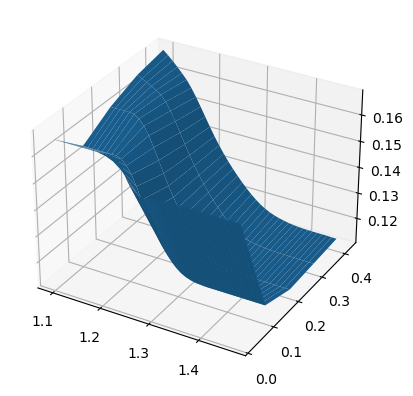

In [258]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    plt.show()
plotTestImpliedVolSurface()